<a href="https://colab.research.google.com/github/theAkhileshRai/ComputerVision/blob/master/SemanticSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Semantic Segmentation

!pip install -U --pre mxnet-cu101mkl  # updating mxnet to at least v1.6
!pip install git+https://github.com/d2l-ai/d2l-en # installing d2l

Requirement already up-to-date: mxnet-cu101mkl in /usr/local/lib/python3.6/dist-packages (1.6.0)
  Cloning https://github.com/d2l-ai/d2l-en to /tmp/pip-req-build-1l75ahqd
  Running command git clone -q https://github.com/d2l-ai/d2l-en /tmp/pip-req-build-1l75ahqd
  Created wheel for d2l: filename=d2l-0.11.4-cp36-none-any.whl size=31756 sha256=c88aac86ce6083ad053b7b3bcc894e446da903c94c529d1a2e57f9fc4cf07d93
  Stored in directory: /tmp/pip-ephem-wheel-cache-qy96rvcc/wheels/82/6f/b8/8422c7ed664272685e3d139b127f89df39d934704a14b2156c
Successfully built d2l


In [0]:
%matplotlib inline
import d2l
from mxnet import gluon, image, np, npx
import os

npx.set_np()

In [0]:
# Saved in the d2l package for later use
d2l.DATA_HUB['voc2012'] = (d2l.DATA_URL + 'VOCtrainval_11-May-2012.tar',
                           '4e443f8a2eca6b1dac8a6c57641b67dd40621a49')

voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')

In [0]:
# Saved in the d2l package for later use
def read_voc_images(voc_dir, is_train=True):
    """Read all VOC feature and label images."""
    txt_fname = os.path.join(voc_dir, 'ImageSets', 'Segmentation',
                             'train.txt' if is_train else 'val.txt')
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    features, labels = [], []
    for i, fname in enumerate(images):
        features.append(image.imread(os.path.join(
            voc_dir, 'JPEGImages', '%s.jpg' % fname)))
        labels.append(image.imread(os.path.join(
            voc_dir, 'SegmentationClass', '%s.png' % fname)))
    return features, labels

train_features, train_labels = read_voc_images(voc_dir, True)

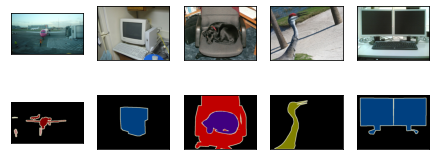

In [0]:
n = 5
imgs = train_features[0:n] + train_labels[0:n]
d2l.show_images(imgs, 2, n);

In [0]:
# Saved in the d2l package for later use
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

# Saved in the d2l package for later use
VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

In [0]:
# Saved in the d2l package for later use
def build_colormap2label():
    """Build an RGB color to label mapping for segmentation."""
    colormap2label = np.zeros(256 ** 3)
    for i, colormap in enumerate(VOC_COLORMAP):
        colormap2label[(colormap[0]*256 + colormap[1])*256 + colormap[2]] = i
    return colormap2label

# Saved in the d2l package for later use
def voc_label_indices(colormap, colormap2label):
    """Map an RGB color to a label."""
    colormap = colormap.astype(np.int32)
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256
           + colormap[:, :, 2])
    return colormap2label[idx]

In [0]:
y = voc_label_indices(train_labels[0], build_colormap2label())
y[105:115, 130:140], VOC_CLASSES[1]

(array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.]]), 'aeroplane')

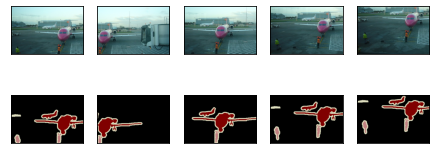

In [16]:
# Saved in the d2l package for later use
def voc_rand_crop(feature, label, height, width):
    """Randomly crop for both feature and label images."""
    feature, rect = image.random_crop(feature, (width, height))
    label = image.fixed_crop(label, *rect)
    return feature, label

imgs = []
for _ in range(n):
    imgs += voc_rand_crop(train_features[0], train_labels[0], 200, 300)
d2l.show_images(imgs[::2] + imgs[1::2], 2, n);

In [0]:
# Saved in the d2l package for later use
class VOCSegDataset(gluon.data.Dataset):
    """A customized dataset to load VOC dataset."""

    def __init__(self, is_train, crop_size, voc_dir):
        self.rgb_mean = np.array([0.485, 0.456, 0.406])
        self.rgb_std = np.array([0.229, 0.224, 0.225])
        self.crop_size = crop_size
        features, labels = read_voc_images(voc_dir, is_train=is_train)
        self.features = [self.normalize_image(feature)
                         for feature in self.filter(features)]
        self.labels = self.filter(labels)
        self.colormap2label = build_colormap2label()
        print('read ' + str(len(self.features)) + ' examples')

    def normalize_image(self, img):
        return (img.astype('float32') / 255 - self.rgb_mean) / self.rgb_std

    def filter(self, imgs):
        return [img for img in imgs if (
            img.shape[0] >= self.crop_size[0] and
            img.shape[1] >= self.crop_size[1])]

    def __getitem__(self, idx):
        feature, label = voc_rand_crop(self.features[idx], self.labels[idx],
                                       *self.crop_size)
        return (feature.transpose(2, 0, 1),
                voc_label_indices(label, self.colormap2label))

    def __len__(self):
        return len(self.features)

In [18]:
crop_size = (320, 480)
voc_train = VOCSegDataset(True, crop_size, voc_dir)
voc_test = VOCSegDataset(False, crop_size, voc_dir)

read 1114 examples
read 1078 examples


In [19]:
batch_size = 64
train_iter = gluon.data.DataLoader(voc_train, batch_size, shuffle=True,
                                   last_batch='discard',
                                   num_workers=d2l.get_dataloader_workers())
for X, Y in train_iter:
    print(X.shape)
    print(Y.shape)
    break

(64, 3, 320, 480)
(64, 320, 480)
